In [1]:
import os
os.environ["HTTP_PROXY"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["HTTPS_PROXY"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["http_proxy"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["https_proxy"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["ftp_proxy"]="http://proxy-01.pub.alcf.anl.gov:3128" 

Last week, Carlo discussed token embedding, which is when words are encoded into a vocabulary. Now, we just discussed attention mechanisms which account for context between words. Another question we should ask is how do we account for the order of words in an input sentence

Consider the following two sentences to see why this is important:

``The man ate the sandwich.``

``The sandwich ate the man.``

Clearly, these are two vastly different situations even though they have the same words. The Transformer can 

Transformers differentiate between these situations by adding a **Positional encoding** vector to each input embedding. These vectors follow a specific pattern that the model learns, which helps it determine the position of each word.

We set up positional encoding similarly as token embedding using the ``nn.Embedding`` tool. We use a simple embedding here but there are more complex positional encodings used such as sinusoidal. 

For an explanation of different positional encodings, refer to this post: https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/

You will notice the positional encoding size is `(block_size, n_embed)` because it encodes for the postion of a token within the sequence of size `block_size`

Then, the position embedding used is simply added to the token embedding to apply positional embedding.

Let's look at token embedding alone:

During the training process, these embeddings will be learned to best encode the token and positional embeddings of the sequences.

The model can calculate the loss between the vector it generates and the ground truth vector seen in this example. A commonly used loss function is cross entropy loss:

$CE = -\sum_{x \in X} p(x) log q(x)$

where p(x) represents the true distribution and q(x) represents the predicted distribution.

Another important metric commonly used in LLMs is **perplexity**.

Intuitively, perplexity means to be surprised. We measure how much the model is surprised by seeing new data. The lower the perplexity, the better the training is.

Mathematically, perplexity is just the exponent of the negative cross entropy loss:

$\text{perplexity} = exp(\text{CE})$

## Let's train a mini-LLM from scratch

### Set up hyperparameters:

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 10
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
# device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}")
eval_iters = 200
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 4
dropout = 0.0
# ------------

Using device cuda


### Load in data and create train and test datasets

We're going to be using the tiny Shakespeare dataset. 
Data is tokenized according to a simple character based tokenizer.
Data is split into a train and test set so we have something to test after performing training (9:1 split).

In [3]:
with open('dataset/input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# print(train_data)

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

### Set up the components of the Decoder block: 
* MultiHeadAttention
* FeedForward Network

In [4]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C) 16,32,16
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd), # Projection layer going back into the residual pathway
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


### Combine components into the Decoder block

In [5]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))    # Communication
        x = x + self.ffwd(self.ln2(x))  # Computation
        return x

### Set up the full Transformer model 
This is a combination of the Token embeddings, Positional embeddings, a stack of Transformer blocks and an output block.

In [6]:
# super simple language model
class LanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx



We will be training a larger LLM on distributed resources in session 6.

## Homework

1. In this notebook, we learned the various components of an LLM. 
    Your homework this week is to take the mini LLM we created from scratch and run your own training loop. Show how the training and validation perplexity change over the steps.
      
    Hint: this function might be useful for you:

In [7]:
model = LanguageModel()
# model.to(device)
# model.eval()


In [8]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.to(device)
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            # X, Y = X.to(device), Y.to(device)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [9]:
from tqdm.notebook import tqdm

loss_his = {'train':[], 'val':[]}

epochs = 30
for j in range(epochs):
    out = estimate_loss()
    train_loss, val_loss = out['train'], out['val']
    loss_his['train'].append(train_loss)
    loss_his['val'].append(val_loss)

    print(f"Epoch {j}: train loss: {train_loss:.3f}, validation loss: {val_loss:.3f}")

Epoch 0: train loss: 4.344, validation loss: 4.347
Epoch 1: train loss: 4.343, validation loss: 4.346
Epoch 2: train loss: 4.343, validation loss: 4.346
Epoch 3: train loss: 4.347, validation loss: 4.347
Epoch 4: train loss: 4.345, validation loss: 4.346
Epoch 5: train loss: 4.344, validation loss: 4.342
Epoch 6: train loss: 4.345, validation loss: 4.347
Epoch 7: train loss: 4.345, validation loss: 4.344
Epoch 8: train loss: 4.345, validation loss: 4.343
Epoch 9: train loss: 4.345, validation loss: 4.340
Epoch 10: train loss: 4.346, validation loss: 4.343
Epoch 11: train loss: 4.341, validation loss: 4.346
Epoch 12: train loss: 4.345, validation loss: 4.344
Epoch 13: train loss: 4.345, validation loss: 4.343
Epoch 14: train loss: 4.348, validation loss: 4.344
Epoch 15: train loss: 4.341, validation loss: 4.343
Epoch 16: train loss: 4.344, validation loss: 4.343
Epoch 17: train loss: 4.347, validation loss: 4.346
Epoch 18: train loss: 4.344, validation loss: 4.344
Epoch 19: train loss: 

Text(0.5, 1.0, 'train loss vs validation loss')

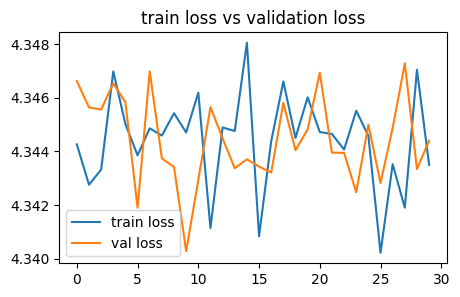

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,3))
plt.plot(loss_his['train'],label='train loss')
plt.plot(loss_his['val'],label='val loss')
plt.legend()
plt.title('train loss vs validation loss')

2. Run the same training loop but modify one of the hyperparameters from this list: 

In [11]:
# hyperparameters
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 4

In [12]:
!pip install optuna

Defaulting to user installation because normal site-packages is not writeable


In [13]:
import optuna

def objective(trial):
    n_embd = trial.suggest_categorical("n_embd", [1,16,32,64,128,256])
    n_head = trial.suggest_categorical("n_head", [1,2,4,8,16])
    n_layer = trial.suggest_categorical("n_layer", [1,2,4,8,16])
    
    model = LanguageModel()
    model.to(device)
    
    validation_loss = estimate_loss()['val']
    return validation_loss
    
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)
    
trial = study.best_trial

print("Loss: {}".format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
    

[I 2024-04-06 22:52:23,774] A new study created in memory with name: no-name-14ea8f57-ca6a-4c41-93e0-2636bb967537
[I 2024-04-06 22:52:28,330] Trial 0 finished with value: 4.340668678283691 and parameters: {'n_embd': 1, 'n_head': 1, 'n_layer': 16}. Best is trial 0 with value: 4.340668678283691.
[I 2024-04-06 22:52:32,384] Trial 1 finished with value: 4.3485493659973145 and parameters: {'n_embd': 256, 'n_head': 2, 'n_layer': 1}. Best is trial 0 with value: 4.340668678283691.
[I 2024-04-06 22:52:36,253] Trial 2 finished with value: 4.342910289764404 and parameters: {'n_embd': 1, 'n_head': 1, 'n_layer': 8}. Best is trial 0 with value: 4.340668678283691.
[I 2024-04-06 22:52:39,686] Trial 3 finished with value: 4.3438310623168945 and parameters: {'n_embd': 256, 'n_head': 1, 'n_layer': 2}. Best is trial 0 with value: 4.340668678283691.
[I 2024-04-06 22:52:44,019] Trial 4 finished with value: 4.346414566040039 and parameters: {'n_embd': 128, 'n_head': 4, 'n_layer': 1}. Best is trial 0 with val

Loss: 4.340668678283691
Best hyperparameters: {'n_embd': 1, 'n_head': 1, 'n_layer': 16}


In [14]:
# hyperparameters
n_embd = trial.params['n_embd']
n_head = trial.params['n_head']
n_layer = trial.params['n_layer']

model = LanguageModel()
# model.to(device)

Epoch 0: train loss: 4.479, validation loss: 4.481
Epoch 1: train loss: 4.477, validation loss: 4.483
Epoch 2: train loss: 4.479, validation loss: 4.483
Epoch 3: train loss: 4.477, validation loss: 4.481
Epoch 4: train loss: 4.478, validation loss: 4.484
Epoch 5: train loss: 4.479, validation loss: 4.480
Epoch 6: train loss: 4.479, validation loss: 4.484
Epoch 7: train loss: 4.479, validation loss: 4.481
Epoch 8: train loss: 4.481, validation loss: 4.483
Epoch 9: train loss: 4.478, validation loss: 4.482
Epoch 10: train loss: 4.478, validation loss: 4.482
Epoch 11: train loss: 4.479, validation loss: 4.483
Epoch 12: train loss: 4.479, validation loss: 4.482
Epoch 13: train loss: 4.477, validation loss: 4.483
Epoch 14: train loss: 4.480, validation loss: 4.485
Epoch 15: train loss: 4.478, validation loss: 4.480
Epoch 16: train loss: 4.479, validation loss: 4.482
Epoch 17: train loss: 4.478, validation loss: 4.481
Epoch 18: train loss: 4.479, validation loss: 4.481
Epoch 19: train loss: 

Text(0.5, 1.0, 'train loss vs validation loss')

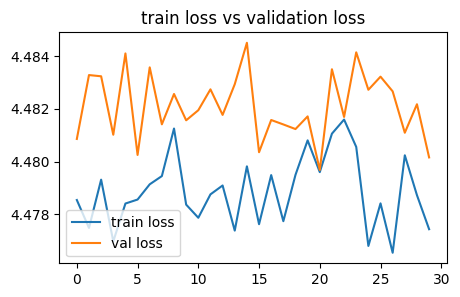

In [15]:
    
import matplotlib.pyplot as plt


loss_his = {'train':[], 'val':[]}

epochs = 30
for j in range(epochs):
    out = estimate_loss()
    train_loss, val_loss = out['train'], out['val']
    loss_his['train'].append(train_loss)
    loss_his['val'].append(val_loss)

    print(f"Epoch {j}: train loss: {train_loss:.3f}, validation loss: {val_loss:.3f}")
    


plt.figure(figsize=(5,3))
plt.plot(loss_his['train'],label='train loss')
plt.plot(loss_his['val'],label='val loss')
plt.legend()
plt.title('train loss vs validation loss')

I tried the parameter optimization tool called optuna to find the best setting of n_embd, n_head and n_layer. However, the best combination suggested by optuna still did not improve the model much.

## References

Here are some recommendations for further reading and additional code for review.

* "The Illustrated Transformer" by Jay Alammar
* "Visualizing A Neural Machine Translation Model (Mechanics of Seq2seq Models With Attention)"
* "The Illustrated GPT-2 (Visualizing Transformer Language Models)"
* "A gentle introduction to positional encoding"
* "LLM Tutorial Workshop (Argonne National Laboratory)"
* "LLM Tutorial Workshop Part 2 (Argonne National Laboratory)"